# "Pythonizing" a Pipeline for AR Visualization: Proof of Concept

In [10]:
#Load needed libraries
#Import needed modules
#general
import astropy.units as u
import numpy as np
import seaborn.apionly as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#sunpy
import sunpy
from sunpy.net import vso
#solarbextrapolation
from solarbextrapolation.map3dclasses import Map3D
from solarbextrapolation.extrapolators import PotentialExtrapolator
from solarbextrapolation.example_data_generator import generate_example_data, dummyDataToMap
#yt
import yt
#chiantipy
import chianti.core as ch
%matplotlib inline

It would be nice to have a way to do AR vizualization all in python. To do this we'll need the ability to do the field line extrapolations, visualize the field lines themselves, map the hydrodynamic simulations to the field lines, and then forward model the intensity.

The workflow might look something like this:

* Query HMI database for relevant magnetogram (using `sunpy`)
* Use `solarbextrapolation` module to do the field extrapolation using PFSS
* Using EBTEL (or HYDRAD), do a hydrodynamic calculation for each of the extrapolated field lines
* Using ChiantiPy, forward model the intensity for a given ion (channel?); once we have improvements here, more accurate and instrument specific forward modeling will be possible.
* Map the intensity back to the extrapolated field lines
* Visualize the AR with `yt`

## Querying an HMI Magnetogram

First, create a new client and add filters for collecting the desired data. This part of the notebook follows exactly from the [sample `solarbrextrapolation` notebook courtesy of SunPy and Alex Hamilton](https://github.com/sunpy/solarbextrapolation).

In [5]:
client = vso.VSOClient()

In [6]:
result_hmi = client.query(
    vso.attrs.Time((2011, 2, 14, 20, 34, 0), (2011, 2, 14, 21, 0, 0)),
    vso.attrs.Instrument('HMI'),
    vso.attrs.Physobs('LOS_magnetic_field'),   # Physical observables
    vso.attrs.Sample(4000 * u.s)  
)

Save the query using FITS files.

In [7]:
data_hmi = client.get(result_hmi, methods=('URL-FILE_Rice', 'URL-FILE')).wait()

Next, let's grab the corresponding AIA data.

In [8]:
result_aia = client.query(
    vso.attrs.Time((2011, 2, 14, 20, 34, 0), (2011, 2, 14, 21, 0, 0)), # Time range.
    vso.attrs.Instrument('AIA'),
    vso.attrs.Physobs('intensity'), 
    vso.attrs.Sample(4000 * u.s)    
)

In [9]:
data_aia = client.get(result_aia, methods=('URL-FILE_Rice', 'URL-FILE')).wait()

Peek at both of the resulting maps to see what the results look like.

/opt/anaconda3/envs/py27/lib/python2.7/site-packages/sunpy-0.7.dev6442-py2.7-linux-x86_64.egg/sunpy/map/mapbase.py:1472: Warning: This map is not properly oriented. Plot axes may be incorrect
  Warning)
/opt/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


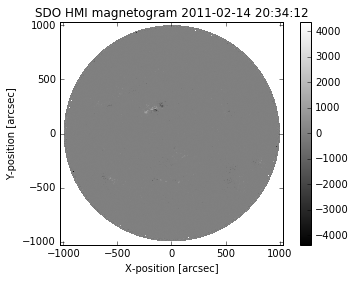

In [11]:
sunpy.map.Map(data_hmi[0]).peek()

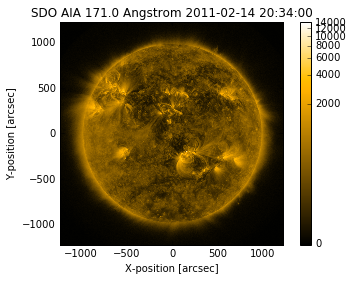

In [12]:
sunpy.map.Map(data_aia[0]).peek()

Next, let's create a submap around the region of interest. We need to crop both images around the active region.

In [19]:
xrange = u.Quantity([50,    300] * u.arcsec)
yrange = u.Quantity([-350, -100] * u.arcsec)
zrange = u.Quantity([0,     250] * u.arcsec)

In [20]:
map_hmi_cropped = sunpy.map.Map(data_hmi[0]).submap(xrange,yrange)

In [21]:
map_aia_cropped = sunpy.map.Map(data_aia[0]).submap(xrange,yrange)

Finally, let's resample the data and have a look at the output.

In [22]:
shape = u.Quantity([20, 20] * u.pixel)
map_hmi_cropped_resampled = map_hmi_cropped.resample(shape, method='linear')
map_aia_cropped_resampled = map_aia_cropped.resample(shape, method='linear')

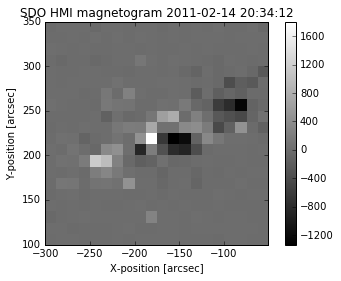

In [23]:
map_hmi_cropped_resampled.peek()

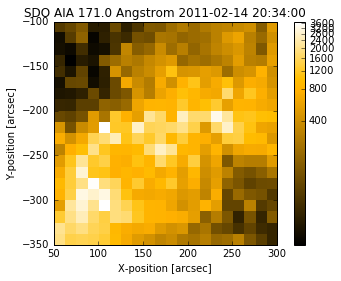

In [24]:
map_aia_cropped_resampled.peek()

## Field Extrapolation
Now that we have the relevant boundary data, we want to perform the field extrapolation with PFSS. 

In [27]:
aPotExt = PotentialExtrapolator(map_hmi_cropped_resampled,zshape=20,zrange=zrange)

In [28]:
aMap3D = aPotExt.extrapolate(enable_numba=True)

False


## Field Line Visualization with `yt`
Now, as a preliminary step, we want to visualize the field lines from the PFSS field extrapolation. First, let's expand the boundary box and recrop the boundary image.

In [30]:
xrangeextended = u.Quantity([ xrange.value[0] - 50, xrange.value[1] + 50 ] * xrange.unit)
yrangeextended = u.Quantity([ yrange.value[0] - 50, yrange.value[1] + 50 ] * yrange.unit)

In [31]:
map_boundary_cropped = sunpy.map.Map(data_hmi[0]).submap(xrangeextended,yrangeextended)

Next, we need to reshape the data into something `yt` can load.

In [32]:
data = dict(
    Bx=(aMap3D.data[:,:,:,0],"T"),
    By=(aMap3D.data[:,:,:,1],"T"),
    Bz=(aMap3D.data[:,:,:,2],"T")
)

In [33]:
bbox = np.array([xrangeextended.value,yrangeextended.value,zrange.value])

In [34]:
ds = yt.load_uniform_grid(data,data['Bx'][0].shape,
                          length_unit="arcsec",bbox=bbox)

yt : [INFO     ] 2016-05-23 14:20:00,790 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-05-23 14:20:00,791 Parameters: domain_dimensions         = [20 20 20]
yt : [INFO     ] 2016-05-23 14:20:00,792 Parameters: domain_left_edge          = [   0. -400.    0.]
yt : [INFO     ] 2016-05-23 14:20:00,793 Parameters: domain_right_edge         = [ 350.  -50.  250.]
yt : [INFO     ] 2016-05-23 14:20:00,794 Parameters: cosmological_simulation   = 0.0


The hard part comes in how exactly to calculate the streamlines. Now, we don't really know exactly where to choose the seedpoints. For now, let's just choose them randomly. at a height of $z\approx1$.

In [68]:
c = ds.domain_center
N = 1000
scale = ds.domain_width[0]
pos_dx = np.random.normal(scale=ds.domain_width[0].value/10,size=(N,3))*ds.domain_width[0]/ds.domain_width.value
pos = c+pos_dx
for p in pos:
    p[-1] = 15.

In [69]:
streamlines = yt.visualization.api.Streamlines(ds, pos, 'Bx', 'By', 'Bz',get_magnitude=True,direction=1)
streamlines.integrate_through_volume()

yt : [INFO     ] 2016-05-23 14:33:39,013 AMRKDTree rebuilt, Final Volume: 3.062500e+07


Plot the fieldlines.

(-400, -50)

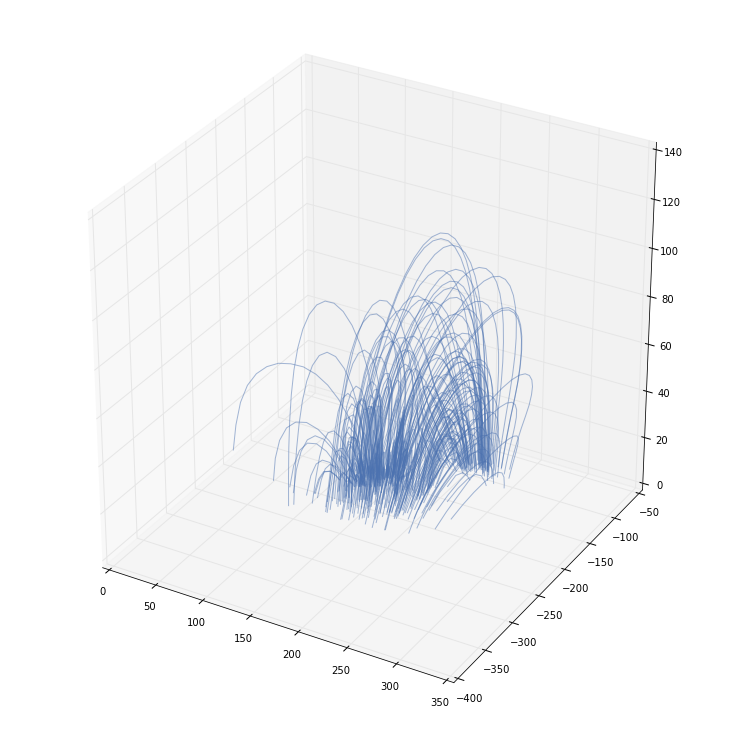

In [73]:
fig=plt.figure(figsize=(10,10))
ax = Axes3D(fig)
for stream in streamlines.streamlines:
    stream = stream[np.all(stream != 0.0, axis=1)]
    if stream[0,2] < 20. and stream[-1,2] < 10.:
        ax.plot3D(stream[:,0], stream[:,1], stream[:,2], alpha=0.5,color=sns.color_palette('deep')[0])
ax.set_xlim([0,350])
ax.set_ylim([-400,-50])

The next step is to extract all of the field strengths and loop lengths. The problem with the latter though is that all of our units are in arcsec and we want them in cgs length units (i.e. cm or Mm).